In [2]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [3]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

In [4]:
def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals


# Dataset Visualization

In [48]:
baseline_dataset_config = {
  "dataset": "color_mnist_add",
    "root_dir": "data/",
    "num_workers": 8,
    "batch_size": 2048,
    "num_operands": 5,
    "selected_digits": [3, 8],
    "count_labels": True,
    "low_noise_level": 1,
    "noise_level": 0.25,
    "test_low_noise_level": 1,
    "test_noise_level": 0.25,
    "train_dataset_size": 500,
    "test_dataset_size": 500,
    "sampling_percent": 1,
    "sampling_groups": True,
    "test_subsampling": 1,
    "weight_loss": False,
    "spurious_strength": 0.1,
    "color_by_label": False,
    "colors": ["random_1", "random_2", "random_3", "random_4", "random_5", "random_6", "random_7", "random_8", "random_9", "random_10"],
    "digit_color_distribution": {
      0: ["spurious", None, None, None, None, None, None, None, None, None],
      1: [None, "spurious", None, None, None, None, None, None, None, None],
      2: [None, None, "spurious", None, None, None, None, None, None, None],
      3: [None, None, None, "spurious", None, None, None, None, None, None],
      4: [None, None, None, None, "spurious", None, None, None, None, None],
      5: [None, None, None, None, None, "spurious", None, None, None, None],
      6: [None, None, None, None, None, None, "spurious", None, None, None],
      7: [None, None, None, None, None, None, None, "spurious", None, None],
      8: [None, None, None, None, None, None, None, None, "spurious", None],
      9: [None, None, None, None, None, None, None, None, None, "spurious"],
    },
    "test_digit_color_distribution": {
      0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      1: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      2: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      3: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      4: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      5: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      6: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      7: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      8: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      9: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    },
}

downstream_spurious_dataset_config = copy.deepcopy(baseline_dataset_config)
downstream_spurious_dataset_config['spurious_strength'] = 0.95
downstream_spurious_dataset_config['color_by_label'] = True

concept_spurious_dataset_config = copy.deepcopy(baseline_dataset_config)
concept_spurious_dataset_config['spurious_strength'] = 0.95
concept_spurious_dataset_config['color_by_label'] = False

ood_dataset_config = copy.deepcopy(baseline_dataset_config)
ood_dataset_config['test_noise_level'] = 0.5

In [49]:
import cem.utils.data as data_utils
import cem.data.color_mnist_add as color_mnist_data_module

n_samples = 5
for (dataset_config, name) in [
    (baseline_dataset_config, "baseline"),
    (downstream_spurious_dataset_config, "downstream spurious"),
    (concept_spurious_dataset_config, "concept spurious"),
    (ood_dataset_config, "OOD"),
]:
    train_dl, val_dl, test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
        color_mnist_data_module.generate_data(
            config=dataset_config,
            seed=42,
            output_dataset_vars=True,
            root_dir=dataset_config.get('root_dir', None),
        )
    x_train, y_train, c_train = data_utils.daloader_to_memory(train_dl)
    fig, axs = plt.subplots(1, 2*n_samples + 1, figsize=(32, 24), dpi=80)
    fig.suptitle(name.upper(), fontsize=80)
    for i in range(n_samples):
        axs[i].set_title(f"Train #{i+1}\nLabel: {y_train[i]}", fontsize=35)
        axs[i].imshow(x_train[i, :, :, :].transpose(1, 2, 0))
        axs[i].axis("off")
    x_test, y_test, c_test = data_utils.daloader_to_memory(test_dl)
    axs[n_samples].axis("off")
    for i in range(n_samples):
        axs[n_samples + 1 + i].set_title(f"Test #{i+1}\nLabel: {y_test[i]}", fontsize=35)
        axs[n_samples + 1 + i].imshow(x_test[i, :, :, :].transpose(1, 2, 0))
        axs[n_samples + 1 + i].axis("off")
    plt.axis(False)
    plt.show()
    print("-"*80)

/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/seed.py:47: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_fabric.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 42


KeyboardInterrupt: 

# Intervention Visualization on Complete MNIST Experiment

In [4]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/color_mnist_count/complete'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Noisy_Count_Baseline_20_cwl_10',
 'Joint CBM (Downstream Spurious)': 'CBM_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'Joint CBM (Concept Spurious)': 'CBM_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_10',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_extra_dims_5_Sigmoid_Noisy_Count_Baseline_20_cwl_10',
 'Hybrid-CBM (Downstream Spurious)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'Hybrid-CBM (Concept Spurious)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_10',
 'CEM (Baseline)': 'CEM_emb_size_32_Noisy_Count_Baseline_20_cwl_10',
 'CEM (Downstream Spurious)': 'CEM_emb_size_32_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'CEM (Concept Spurious)': 'CEM_emb_size_16_Noisy_Count_Concept_Spurious_20_cwl_10',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_0.1_intervention_task_discount_1.5_Noisy_Count_Baseline_20_cwl_10',
 'IntCEM (Concept Spurious)': 'IntCEM_emb_size_8_intervention_weight_0

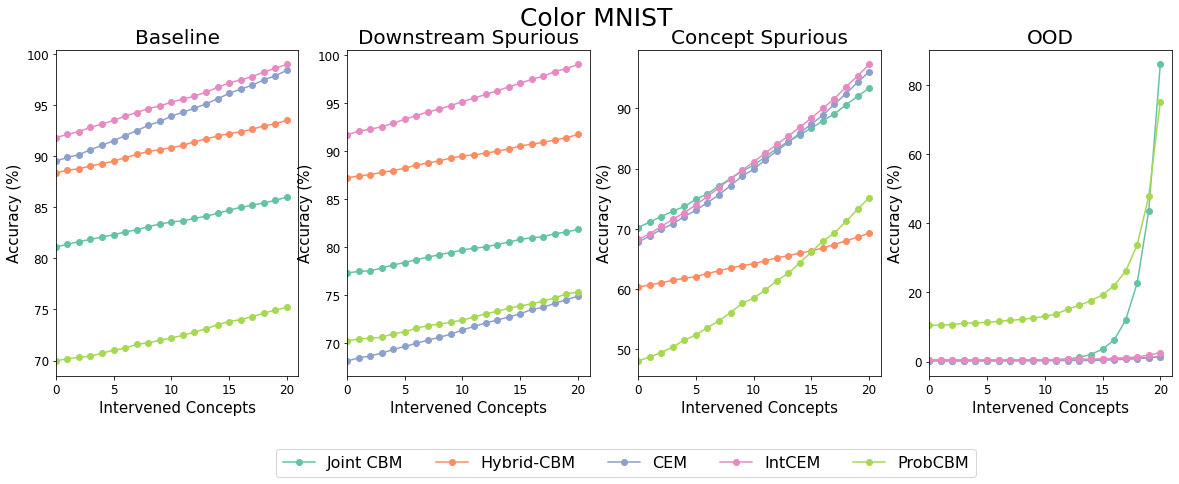

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, 21))
rename_map = {
    "Mixing-CEM": "MixCEM",
    "ResidualMixing-CEM": "MixCEM (with intervention loss)",
}
for ax, (mode_name, mode_key) in zip(
    axs,
    [
        ("Baseline", " (Baseline)"),
        ("Downstream Spurious", " (Downstream Spurious)"),
        ("Concept Spurious", " (Concept Spurious)"),
        ("OOD", " (Baseline)"),
    ]
):
    for idx, label in enumerate([
        "Joint CBM",
        "Hybrid-CBM",
        "CEM",
        "IntCEM",
        "ProbCBM",
    ]):
        model_name = selected_models.get(
            label + mode_key,
            label,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_' if mode_name == 'OOD' else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = clrs[idx]
        ax.plot(
            means,
            "-x" if "MixCEM" in label else "-o",
            color=color,
            label=label,
        )
        # ax.scatter(
        #     xticks,
        #     means,
        #     color=color,
        #     marker="x" if "MixCEM" in label else ".",
        # )
        # ax.fill_between(
        #     xticks,
        #     means - stds,
        #     means + stds,
        #     alpha=0.2,
        #     facecolor=color,
        # )
    ax.set_xlim(0, len(means))
    # ax.set_xticks(xticks)
    ax.set_ylabel("Accuracy (%)", fontsize=15)
    ax.set_xlabel("Intervened Concepts", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(mode_name, fontsize=20)
    handles, labels = ax.get_legend_handles_labels()
fig.suptitle("Color MNIST", fontsize=25)
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-1.25,-0.2),
    ncol=5,
)
plt.show()

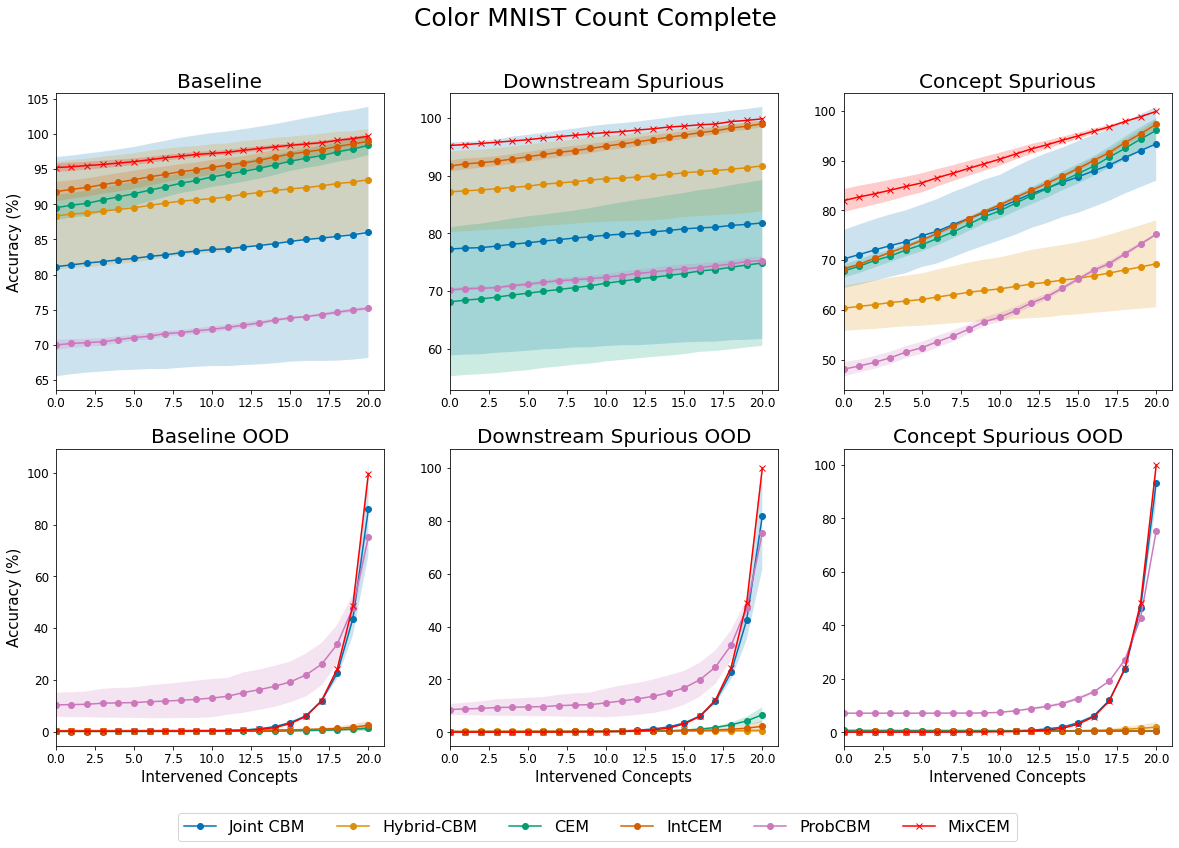

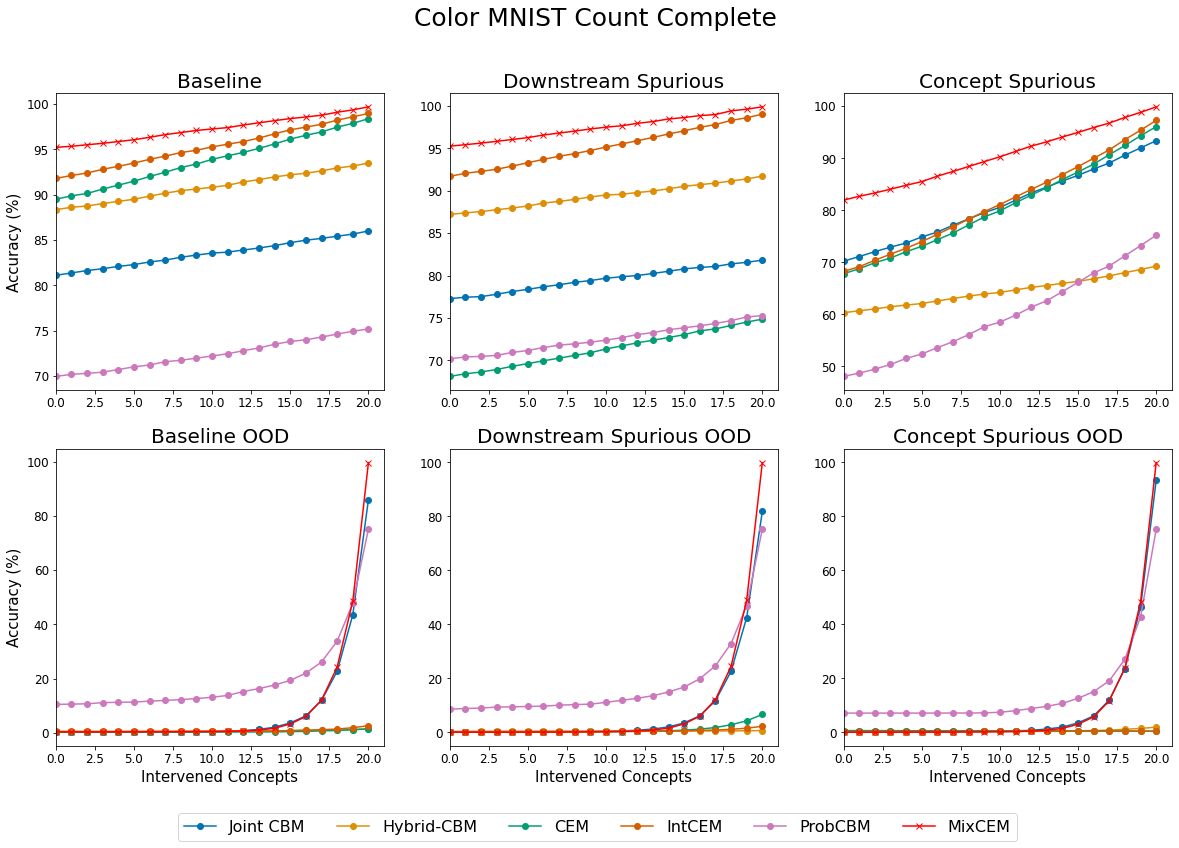

In [6]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 21))
rename_map = {
    # "Mixing-CEM": "MixCEM",
    # "ResidualMixing-CEM": "MixCEM (with intervention loss)",
    "ResidualMixing-CEM": "MixCEM",
}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Downstream Spurious", " (Downstream Spurious)", (0, 1)),
            ("Concept Spurious", " (Concept Spurious)", (0, 2)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
            ("Downstream Spurious OOD", " (Downstream Spurious)", (1, 1)),
            ("Concept Spurious OOD", " (Concept Spurious)", (1, 2)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "ResidualMixing-CEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("Color MNIST Count Complete", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(-0.75,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/color_mnist_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/color_mnist_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# 50% Incomplete Color MNIST Experiment

In [24]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/color_mnist_count/incomplete'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models


{'Joint CBM (Baseline)': 'CBM_Sigmoid_Noisy_Count_Baseline_20_cwl_1',
 'Joint CBM (Downstream Spurious)': 'CBM_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_1',
 'Joint CBM (Concept Spurious)': 'CBM_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_1',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Baseline_20_cwl_10',
 'Hybrid-CBM (Downstream Spurious)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'Hybrid-CBM (Concept Spurious)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_10',
 'CEM (Baseline)': 'CEM_emb_size_8_Noisy_Count_Baseline_20_cwl_10',
 'CEM (Downstream Spurious)': 'CEM_emb_size_32_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'CEM (Concept Spurious)': 'CEM_emb_size_32_Noisy_Count_Concept_Spurious_20_cwl_10',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_0.1_intervention_task_discount_1.5_Noisy_Count_Baseline_20_cwl_10',
 'IntCEM (Concept Spurious)': 'IntCEM_emb_size_8_intervention_weight_0.1_

label Joint CBM means [42.69333333 39.65333333 35.97333333 32.17333333 29.22666667 25.80666667
 23.18666667 20.90666667 19.07333333 17.20666667 16.01333333]
label Hybrid-CBM means [73.28666667 73.5        73.82666667 74.08666667 74.36666667 74.56
 74.86       75.12666667 75.28666667 75.54       75.72666667]
label CEM means [70.98666667 71.25333333 71.57333333 71.93333333 72.24666667 72.58
 72.84666667 73.16       73.53333333 73.94       74.26      ]
label IntCEM means [70.64       70.92       71.14       71.34       71.60666667 71.82
 72.2        72.48       72.80666667 73.14666667 73.36666667]
label ProbCBM means [22.62       22.66666667 22.80666667 22.87333333 23.06       23.21333333
 23.42       23.96       24.19333333 24.48666667 24.61333333]
label MixCEM means [74.97333333 74.96666667 75.09333333 75.11333333 75.13333333 75.18
 75.32666667 75.24666667 75.3        75.41333333 75.50666667]
label Joint CBM means [36.83333333 33.82666667 30.83333333 27.51333333 24.52666667 21.75333333


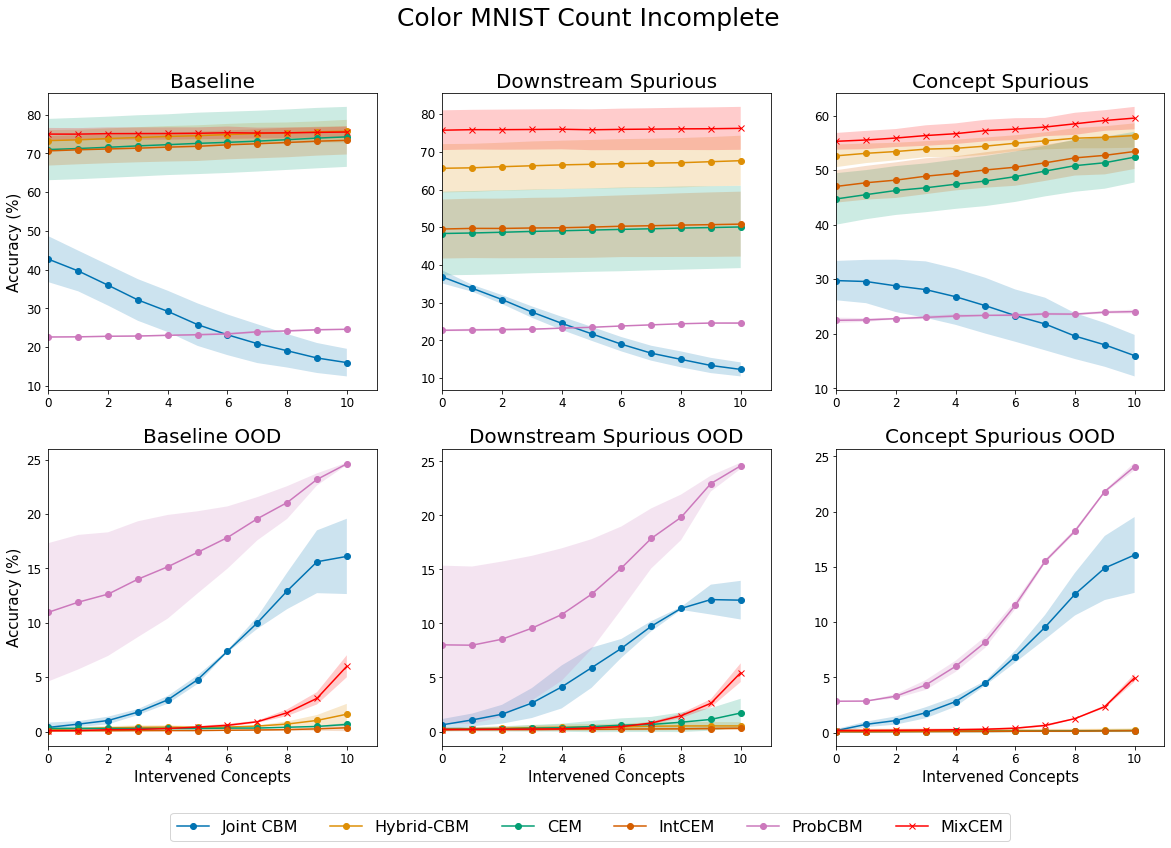

label Joint CBM means [42.69333333 39.65333333 35.97333333 32.17333333 29.22666667 25.80666667
 23.18666667 20.90666667 19.07333333 17.20666667 16.01333333]
label Hybrid-CBM means [73.28666667 73.5        73.82666667 74.08666667 74.36666667 74.56
 74.86       75.12666667 75.28666667 75.54       75.72666667]
label CEM means [70.98666667 71.25333333 71.57333333 71.93333333 72.24666667 72.58
 72.84666667 73.16       73.53333333 73.94       74.26      ]
label IntCEM means [70.64       70.92       71.14       71.34       71.60666667 71.82
 72.2        72.48       72.80666667 73.14666667 73.36666667]
label ProbCBM means [22.62       22.66666667 22.80666667 22.87333333 23.06       23.21333333
 23.42       23.96       24.19333333 24.48666667 24.61333333]
label MixCEM means [74.97333333 74.96666667 75.09333333 75.11333333 75.13333333 75.18
 75.32666667 75.24666667 75.3        75.41333333 75.50666667]
label Joint CBM means [36.83333333 33.82666667 30.83333333 27.51333333 24.52666667 21.75333333


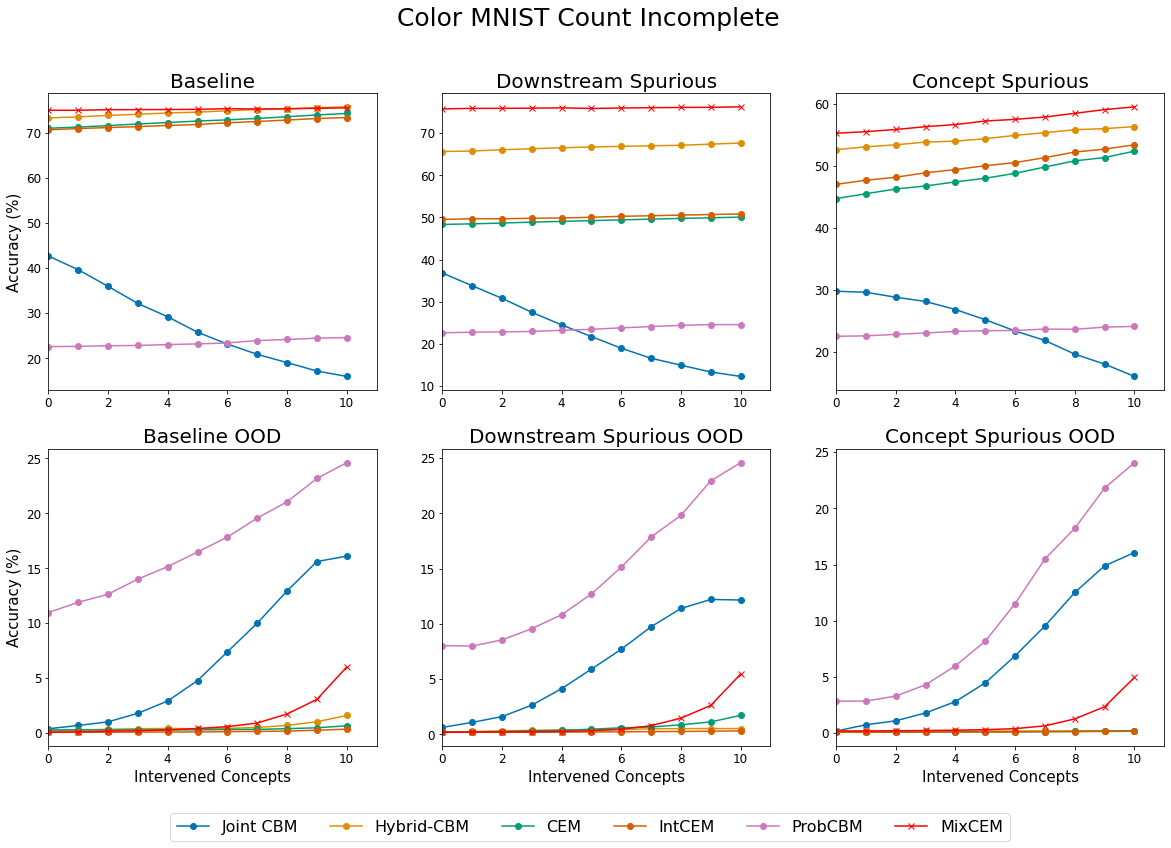

In [25]:

clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 11))
rename_map = {
    # "Mixing-CEM": "MixCEM",
    # "ResidualMixing-CEM": "MixCEM (with intervention loss)",
    "ResidualMixing-CEM": "MixCEM",
}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Downstream Spurious", " (Downstream Spurious)", (0, 1)),
            ("Concept Spurious", " (Concept Spurious)", (0, 2)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
            ("Downstream Spurious OOD", " (Downstream Spurious)", (1, 1)),
            ("Concept Spurious OOD", " (Concept Spurious)", (1, 2)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "ResidualMixing-CEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            print("label", label, "means", means)
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("Color MNIST Count Incomplete", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(-0.75,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/color_mnist_incomplete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/color_mnist_incomplete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

## CUB Incomplete

In [9]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/cub_incomplete/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Baseline_cwl_5',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_100_Baseline_cwl_5',
 'CEM (Baseline)': 'CEM_Baseline_cwl_5',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_5',
 'MixCEM (Baseline)': 'MixCEM_n_extra_25_entr_0_dis_1.01_ip_[0.25, 0.5, 0.75, 1]_dip_0.25_cl_0_mix_True_shared_True_emb_size_1024_ml_0_Baseline_cwl_0.1',
 'ProbCBM (Baseline)': 'ProbCBM_cwl_class_hidden_dim_256_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75'}

Baseline Joint CBM means = [17.85180071 19.89414337 22.13209067 24.91658037 27.52847774 30.48555977
 33.05718559 35.60004602]
Baseline Hybrid-CBM means = [28.01173628 29.80669658 32.05039696 34.2538258  36.56656311 39.06339892
 41.46818548 43.95926821]
Baseline CEM means = [71.43596824 74.44482798 77.58025544 80.94005293 84.24231964 87.18214245
 89.8745829  92.17006098]
Baseline IntCEM means = [70.29110574 74.76124727 78.82292026 82.79254401 86.82545162 90.3693476
 93.5450466  96.04763548]
Baseline ProbCBM means = [58.08882752 61.54067426 65.72891497 70.47520423 75.00287654 79.61109193
 83.69002416 87.740191  ]
Baseline MixCEM means = [69.29007019 75.22724658 80.43953515 85.6575768  89.73075595 92.9467265
 95.77724082 97.80807732]
Baseline OOD Joint CBM means = [ 0.5465424   1.08157864  2.50258889  5.26406628  9.69968933 17.09239443
 25.7680359  35.60004602]
Baseline OOD Hybrid-CBM means = [0.60407318 0.74214705 1.08157864 1.5878495  2.27821885 3.29651363
 4.60246232 6.28811414]
Baseli

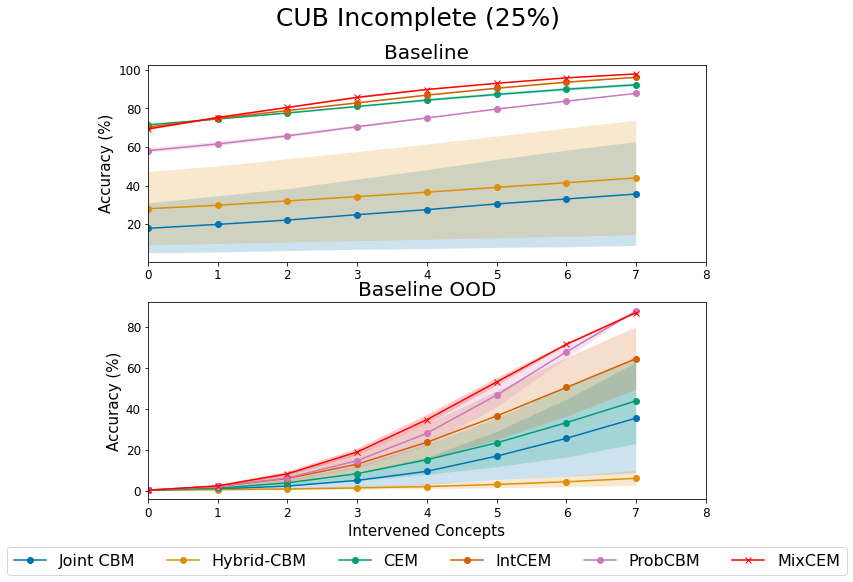

Baseline Joint CBM means = [17.85180071 19.89414337 22.13209067 24.91658037 27.52847774 30.48555977
 33.05718559 35.60004602]
Baseline Hybrid-CBM means = [28.01173628 29.80669658 32.05039696 34.2538258  36.56656311 39.06339892
 41.46818548 43.95926821]
Baseline CEM means = [71.43596824 74.44482798 77.58025544 80.94005293 84.24231964 87.18214245
 89.8745829  92.17006098]
Baseline IntCEM means = [70.29110574 74.76124727 78.82292026 82.79254401 86.82545162 90.3693476
 93.5450466  96.04763548]
Baseline ProbCBM means = [58.08882752 61.54067426 65.72891497 70.47520423 75.00287654 79.61109193
 83.69002416 87.740191  ]
Baseline MixCEM means = [69.29007019 75.22724658 80.43953515 85.6575768  89.73075595 92.9467265
 95.77724082 97.80807732]
Baseline OOD Joint CBM means = [ 0.5465424   1.08157864  2.50258889  5.26406628  9.69968933 17.09239443
 25.7680359  35.60004602]
Baseline OOD Hybrid-CBM means = [0.60407318 0.74214705 1.08157864 1.5878495  2.27821885 3.29651363
 4.60246232 6.28811414]
Baseli

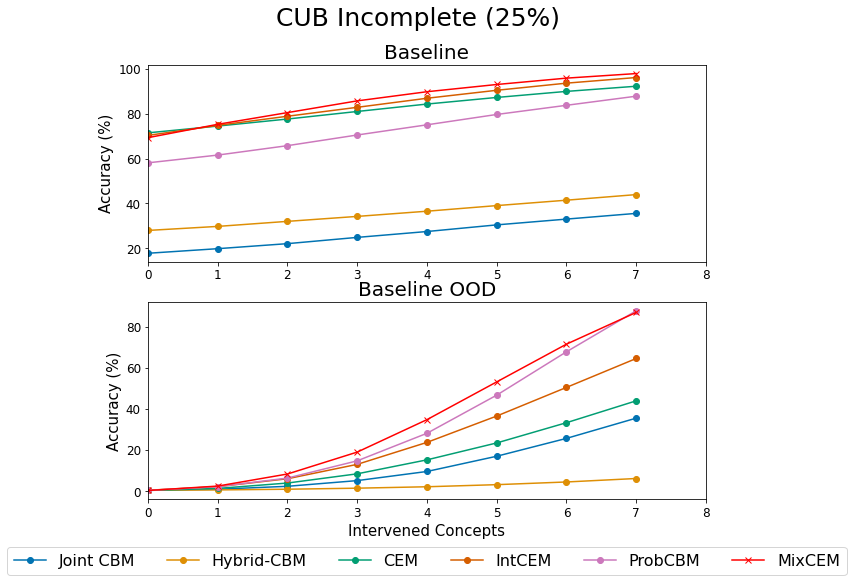

In [10]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 8))
rename_map = {}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "MixCEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("CUB Incomplete (25%)", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/cub_incomplete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/cub_incomplete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

## CUB Complete

In [11]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/cub_complete/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Baseline_cwl_5',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5',
 'CEM (Baseline)': 'CEM_Baseline_cwl_5',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_5',
 'MixCEM (Baseline)': 'MixCEM_n_extra_50_entr_0_dis_1.01_ip_[0.25, 0.5, 0.75, 1]_dip_0.1_cl_0_mix_True_shared_True_emb_size_256_ml_0_Baseline_cwl_1',
 'ProbCBM (Baseline)': 'ProbCBM_cwl_class_hidden_dim_128_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75'}

Baseline Joint CBM means = [72.35070763 73.7371994  75.25601197 76.64250374 77.99447705 79.68012887
 81.37153377 83.09170406 84.65654125 86.34794615 87.88977103 89.63295363
 91.00793925 92.02048096 93.3379358  94.28144057 94.93729145 95.52985847
 96.00161086 96.381314   96.68047405 96.99114026 97.19825106 97.38810263
 97.54918882 97.62397883 97.68726269 97.77355885 97.85410194]
Baseline Hybrid-CBM means = [73.65090323 74.7785065  75.7680359  77.02220688 78.16706938 79.50178345
 80.68116442 81.84903924 82.98814866 84.21930733 85.45621908 86.73340237
 88.03359797 89.23023818 90.35208837 91.42791393 92.50949258 93.39546657
 94.2469221  94.85674836 95.50109308 96.05338856 96.5654125  96.85881947
 97.10044874 97.34207801 97.60096652 97.85985502 98.06696583]
Baseline CEM means = [75.89460361 77.28109539 78.81716718 80.30146128 81.60740996 83.07444483
 84.4609366  85.7898976  87.11885859 88.38453573 89.67897825 90.82959383
 91.88240709 92.7913934  93.63134277 94.41951444 94.98331607 95.644920

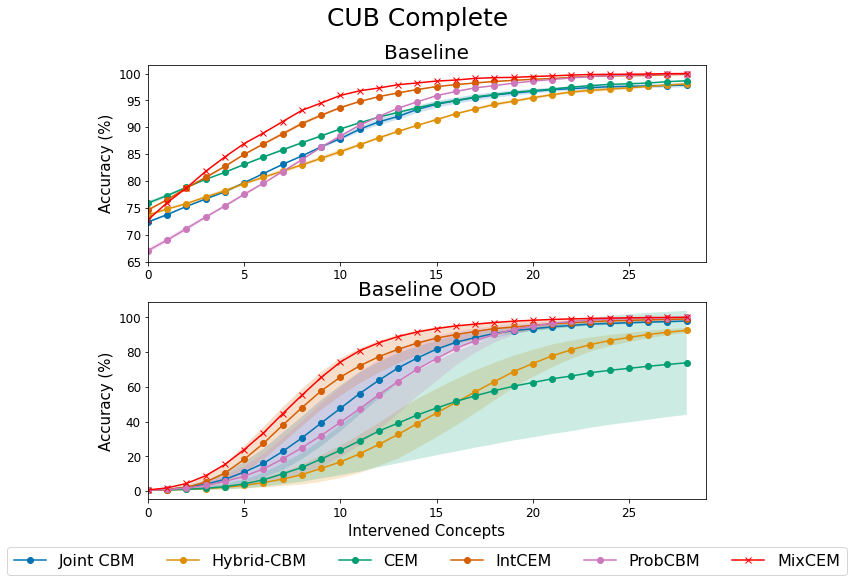

Baseline Joint CBM means = [72.35070763 73.7371994  75.25601197 76.64250374 77.99447705 79.68012887
 81.37153377 83.09170406 84.65654125 86.34794615 87.88977103 89.63295363
 91.00793925 92.02048096 93.3379358  94.28144057 94.93729145 95.52985847
 96.00161086 96.381314   96.68047405 96.99114026 97.19825106 97.38810263
 97.54918882 97.62397883 97.68726269 97.77355885 97.85410194]
Baseline Hybrid-CBM means = [73.65090323 74.7785065  75.7680359  77.02220688 78.16706938 79.50178345
 80.68116442 81.84903924 82.98814866 84.21930733 85.45621908 86.73340237
 88.03359797 89.23023818 90.35208837 91.42791393 92.50949258 93.39546657
 94.2469221  94.85674836 95.50109308 96.05338856 96.5654125  96.85881947
 97.10044874 97.34207801 97.60096652 97.85985502 98.06696583]
Baseline CEM means = [75.89460361 77.28109539 78.81716718 80.30146128 81.60740996 83.07444483
 84.4609366  85.7898976  87.11885859 88.38453573 89.67897825 90.82959383
 91.88240709 92.7913934  93.63134277 94.41951444 94.98331607 95.644920

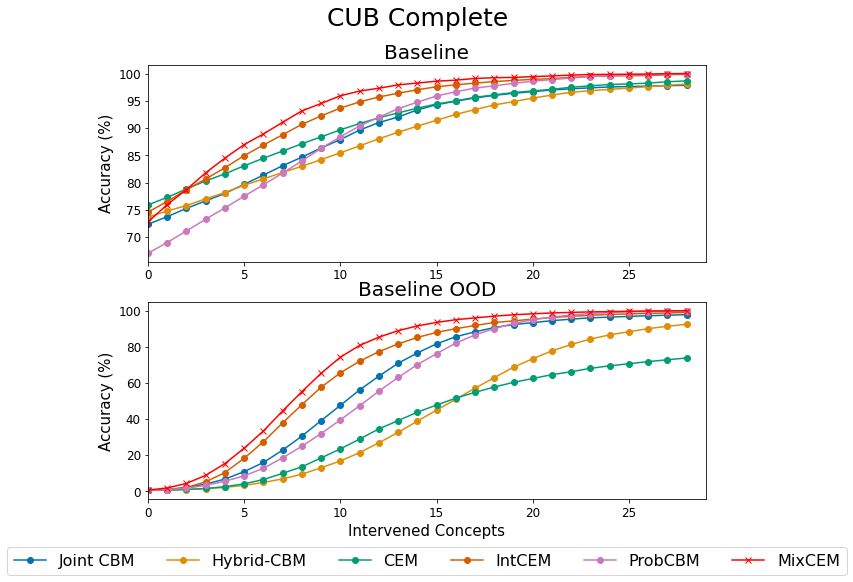

In [12]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 29))
rename_map = {}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "MixCEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("CUB Complete", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/cub_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/cub_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# CelebA

In [ ]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/celeba/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'DNN (Baseline)': 'DNN',
 'Joint CBM (Baseline)': 'CBM_Sigmoid_Baseline_cwl_1',
 'Joint Logit CBM (Baseline)': 'CBM_Logit_Baseline_cwl_1',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1',
 'CEM (Baseline)': 'CEM',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_5_intervention_task_discount_1.5',
 'MixCEM (Baseline)': 'MixCEM_n_extra_100_entr_0_dis_1.05_ip_[0.25, 0.5, 0.75, 1]_dip_0.1_cl_0_mix_True_shared_True_emb_size_64_ml_0_Baseline_cwl_10',
 'ProbCBM (Baseline)': 'ProbCBM_cwl_class_hidden_dim_32_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75'}

Baseline Joint CBM means = [23.87440758 25.671406   27.97195893 30.38112164 33.17535545 36.19668246
 40.17575039]
Baseline Hybrid-CBM means = [27.85347551 28.32740916 28.71248025 29.24565561 29.64060032 30.16390205
 30.75631912]
Baseline CEM means = [30.05529226 32.60268562 35.3771722  38.1121643  41.70616114 44.94470774
 49.27922591]
Baseline IntCEM means = [37.27290679 41.0150079  45.57661927 50.45418641 56.42772512 62.58886256
 69.07582938]
Baseline ProbCBM means = [31.49684044 35.06121643 39.29699842 44.3621643  49.51619273 55.88467615
 62.98380727]
Baseline MixCEM means = [32.12875197 36.19668246 40.63981043 45.44826224 51.46129542 58.55055292
 66.87401264]
Baseline OOD Joint CBM means = [10.75236967 11.06832543 12.65797788 16.12361769 22.82780411 30.61808847
 40.17575039]
Baseline OOD Hybrid-CBM means = [8.32345972 8.45181675 8.55055292 8.67890995 8.84676145 8.93562401
 8.99486572]
Baseline OOD CEM means = [10.31793049 10.72274882 11.25592417 12.02606635 13.48736177 15.37322275
 

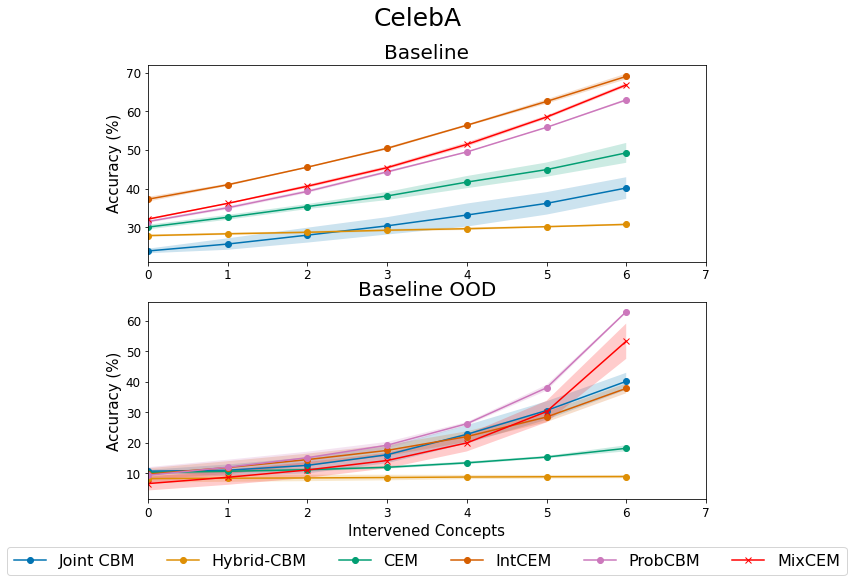

Baseline Joint CBM means = [23.87440758 25.671406   27.97195893 30.38112164 33.17535545 36.19668246
 40.17575039]
Baseline Hybrid-CBM means = [27.85347551 28.32740916 28.71248025 29.24565561 29.64060032 30.16390205
 30.75631912]
Baseline CEM means = [30.05529226 32.60268562 35.3771722  38.1121643  41.70616114 44.94470774
 49.27922591]
Baseline IntCEM means = [37.27290679 41.0150079  45.57661927 50.45418641 56.42772512 62.58886256
 69.07582938]
Baseline ProbCBM means = [31.49684044 35.06121643 39.29699842 44.3621643  49.51619273 55.88467615
 62.98380727]
Baseline MixCEM means = [32.12875197 36.19668246 40.63981043 45.44826224 51.46129542 58.55055292
 66.87401264]
Baseline OOD Joint CBM means = [10.75236967 11.06832543 12.65797788 16.12361769 22.82780411 30.61808847
 40.17575039]
Baseline OOD Hybrid-CBM means = [8.32345972 8.45181675 8.55055292 8.67890995 8.84676145 8.93562401
 8.99486572]
Baseline OOD CEM means = [10.31793049 10.72274882 11.25592417 12.02606635 13.48736177 15.37322275
 

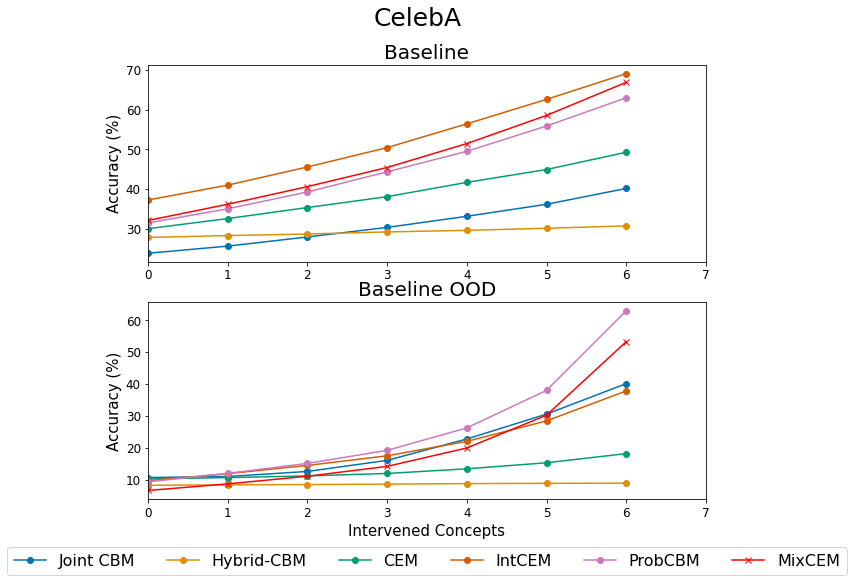

In [ ]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 7))
rename_map = {}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "MixCEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("CelebA", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/celeba{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/celeba{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# Waterbirds (bird features as concepts)

In [7]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/waterbirds_complete/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Baseline_cwl_5',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5',
 'CEM (Baseline)': 'CEM_Baseline_cwl_5',
 'DNN (Baseline)': 'DNN_extra_dims_100',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_5_intervention_task_discount_1.5_Baseline_cwl_5',
 'MixCEM (Baseline)': 'MixCEM_n_extra_0_entr_0_dis_1.01_ip_[0.25, 0.5, 0.75, 1]_dip_0.1_cl_0_mix_True_shared_True_emb_size_32_ml_0_Baseline_cwl_1',
 'ProbCBM (Baseline)': 'ProbCBM_class_hidden_dim_64_hidden_dim_16_cwl_1'}

In [ ]:
MixCEM_n_extra_0_entr_0_dis_1.01_ip_[0.25, 0.5, 0.75, 1]_dip_0.1_cl_0_mix_True_shared_True_emb_size_128_ml_0_Baseline_cwl_10

Baseline Joint CBM means = [82.44735934 82.80405017 83.08019791 83.37360488 83.89713497 83.96041882
 84.15602347 84.55873893 84.76009665 85.16856518 85.41019445 85.83592222
 86.29041537 86.46300771 86.64135312 86.87147624 87.10735243 87.17638937
 87.09584628 87.19940168 87.33747555 87.39500633 87.63088252 87.66540099
 87.73443792 87.67115407 87.55609251 87.57335174 87.72868485]
Baseline Hybrid-CBM means = [83.01116097 83.03417328 83.12046945 83.19525946 83.24703716 83.3160741
 83.50592567 83.51743183 83.53469106 83.62674031 83.6555057  83.76481418
 83.83960419 83.84535727 83.88562881 83.93740651 84.01219653 84.06397423
 84.12150501 84.10999885 84.12150501 84.20780117 84.15027039 84.17903578
 84.24807272 84.38039351 84.39765274 84.50696122 84.63928202]
Baseline CEM means = [80.62938672 80.66965827 80.72718905 80.75595444 80.79622598 80.89402831
 80.96881832 81.00908986 81.08387988 81.04936141 81.16442297 81.10689219
 81.11264527 81.1299045  81.16442297 81.2852376  81.29674376 81.4002991

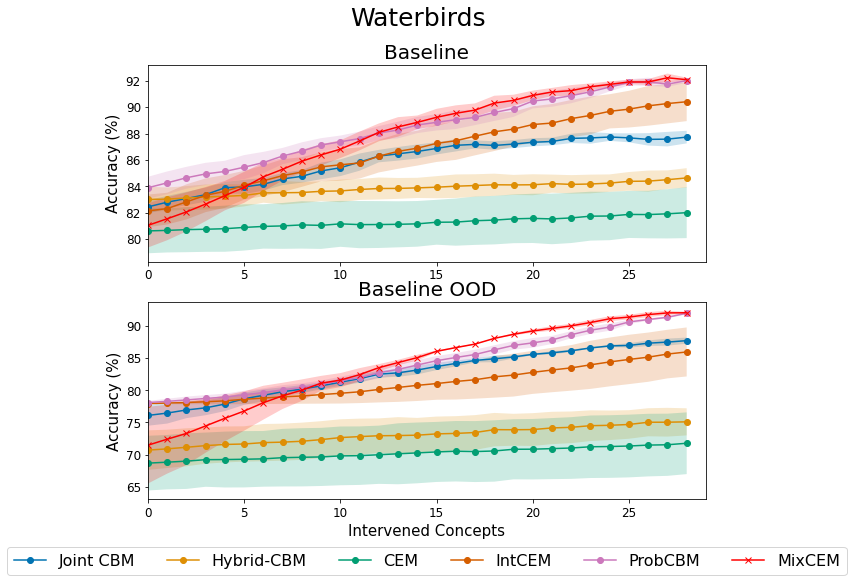

Baseline Joint CBM means = [82.44735934 82.80405017 83.08019791 83.37360488 83.89713497 83.96041882
 84.15602347 84.55873893 84.76009665 85.16856518 85.41019445 85.83592222
 86.29041537 86.46300771 86.64135312 86.87147624 87.10735243 87.17638937
 87.09584628 87.19940168 87.33747555 87.39500633 87.63088252 87.66540099
 87.73443792 87.67115407 87.55609251 87.57335174 87.72868485]
Baseline Hybrid-CBM means = [83.01116097 83.03417328 83.12046945 83.19525946 83.24703716 83.3160741
 83.50592567 83.51743183 83.53469106 83.62674031 83.6555057  83.76481418
 83.83960419 83.84535727 83.88562881 83.93740651 84.01219653 84.06397423
 84.12150501 84.10999885 84.12150501 84.20780117 84.15027039 84.17903578
 84.24807272 84.38039351 84.39765274 84.50696122 84.63928202]
Baseline CEM means = [80.62938672 80.66965827 80.72718905 80.75595444 80.79622598 80.89402831
 80.96881832 81.00908986 81.08387988 81.04936141 81.16442297 81.10689219
 81.11264527 81.1299045  81.16442297 81.2852376  81.29674376 81.4002991

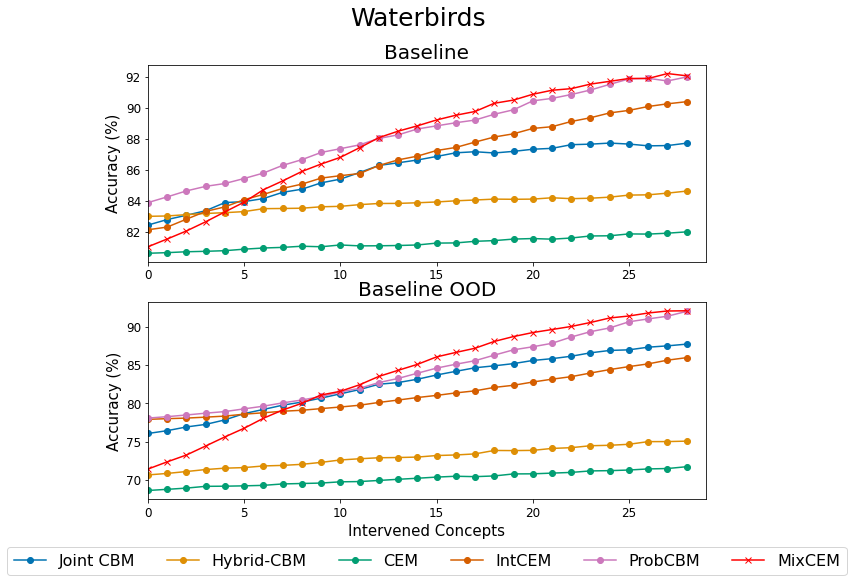

In [8]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 29))
rename_map = {}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "MixCEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("Waterbirds", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/waterbirds_attributes{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/waterbirds_attributes{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# Bird Waterbirds (species as labels)

In [21]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/waterbirds_species/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Baseline_cwl_0.1',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_100_Baseline_cwl_0.1',
 'CEM (Baseline)': 'CEM_Baseline_emb_size_8_cwl_1',
 'DNN (Baseline)': 'DNN_extra_dims_100',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_0.1',
 'MixCEM (Baseline)': 'MixCEM_n_extra_0_entr_0_dis_1.01_ip_[0.25, 0.5, 0.75, 1]_dip_0.1_cl_0_mix_True_shared_True_emb_size_32_ml_0_Baseline_cwl_0.1',
 'ProbCBM (Baseline)': 'ProbCBM_class_hidden_dim_8_hidden_dim_8_cwl_1'}

Baseline Joint CBM means = [89.11632302 89.27521768 89.15710788 89.43913312 89.73895561 90.24332111
 91.95523928 95.12071459 99.89894461]
Baseline Hybrid-CBM means = [86.97916669 86.97746259 86.97649956 86.97401428 86.97535157 86.97847985
 86.97522702 86.97733076 86.96950411]
Baseline CEM means = [87.48032941 87.4807553  87.4845666  87.48831976 87.48681815 87.48917855
 87.48677727 87.49370718 87.49271513]
Baseline IntCEM means = [83.31541657 83.41482109 83.45612426 83.54197594 83.6426449  83.71142692
 83.79287348 83.87927076 83.951808  ]
Baseline ProbCBM means = [50. 50. 50. 50. 50. 50. 50. 50. 50.]
Baseline MixCEM means = [ 83.34949464  86.43366885  88.68613523  91.4567025   94.0737165
  96.28450986  98.34292067  99.63301318 100.        ]
Baseline OOD Joint CBM means = [63.68146412 65.29703065 67.48114363 70.26528278 73.45430971 77.17143177
 82.78226758 90.78886127 99.89894461]
Baseline OOD Hybrid-CBM means = [61.47420813 61.47470889 61.4781186  61.47500994 61.48865466 61.48978842
 61

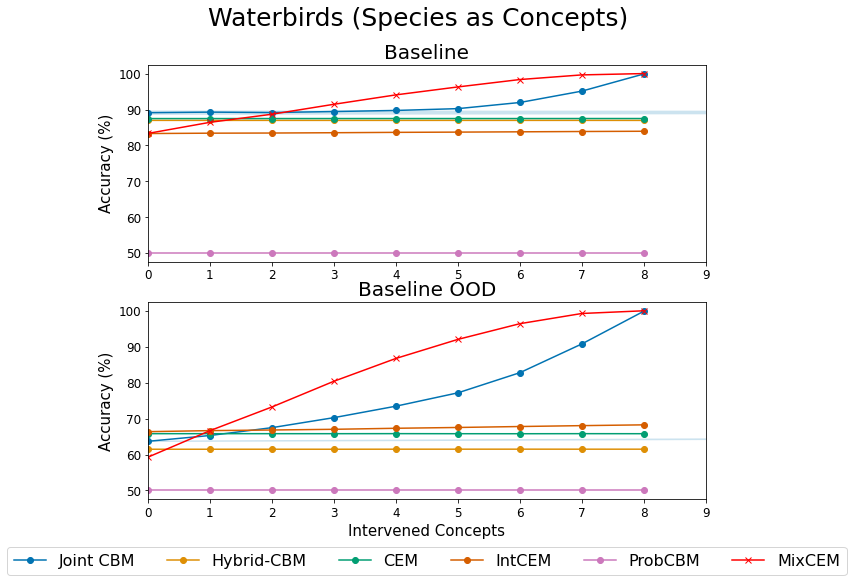

Baseline Joint CBM means = [89.11632302 89.27521768 89.15710788 89.43913312 89.73895561 90.24332111
 91.95523928 95.12071459 99.89894461]
Baseline Hybrid-CBM means = [86.97916669 86.97746259 86.97649956 86.97401428 86.97535157 86.97847985
 86.97522702 86.97733076 86.96950411]
Baseline CEM means = [87.48032941 87.4807553  87.4845666  87.48831976 87.48681815 87.48917855
 87.48677727 87.49370718 87.49271513]
Baseline IntCEM means = [83.31541657 83.41482109 83.45612426 83.54197594 83.6426449  83.71142692
 83.79287348 83.87927076 83.951808  ]
Baseline ProbCBM means = [50. 50. 50. 50. 50. 50. 50. 50. 50.]
Baseline MixCEM means = [ 83.34949464  86.43366885  88.68613523  91.4567025   94.0737165
  96.28450986  98.34292067  99.63301318 100.        ]
Baseline OOD Joint CBM means = [63.68146412 65.29703065 67.48114363 70.26528278 73.45430971 77.17143177
 82.78226758 90.78886127 99.89894461]
Baseline OOD Hybrid-CBM means = [61.47420813 61.47470889 61.4781186  61.47500994 61.48865466 61.48978842
 61

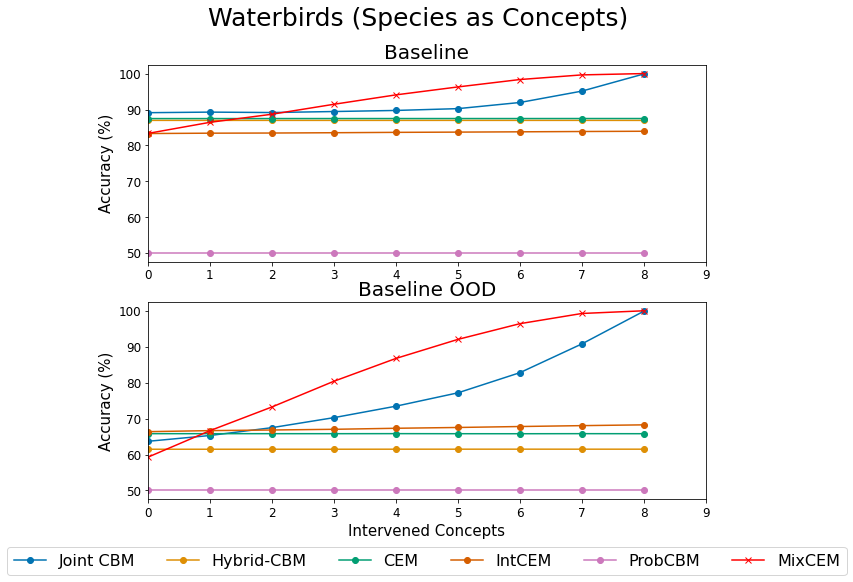

In [22]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 201, 25))
rename_map = {}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "MixCEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("Waterbirds (Species as Concepts)", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/waterbirds_species{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/waterbirds_species{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# Sandbox

In [39]:
CONCEPT_SEMANTICS_SENTENCE_TEST = [
    "a bird with a dagger bill",
    "a bird with am all-purpose bill",
    "a bird with brown wings",
    "a bird with dark black wings",
    "a bird with white wings",
    "a brown bird",
    "a dark black bird",
    "a white bird",
]

IDXs = [
    1,
    6,
    10,
    20,
    21,
    249,
    259,
    260,
]


CONCEPT_SEMANTICS_NEGATION_TEST = [
    "a bird with a bill",
    "a bird with a bill",
    "bird wings",
    "bird wings",
    "bird wings",
    "a bird",
    "a bird",
    "a bird",
]

In [1]:
import os
import numpy as np
import pandas as pd

def attr_line_to_val(line):
    return int(line.split(" ")[2])

def get_sample_attributes(idx, lines):
    return np.array([
        attr_line_to_val(lines[x]) for x in range((idx - 1) * 312, idx * 312)
    ])
    
root_dir = "/anfs/bigdisc/me466/waterbirds"
cub_root_dir = "/homes/me466/data/CUB200/"
metadata_df = pd.read_csv(
    os.path.join(root_dir, 'metadata.csv')
)
image_true_idx = metadata_df['img_id'].values
with open(
    os.path.join(
        cub_root_dir,
        'CUB_200_2011/attributes/image_attribute_labels.txt',
    ),
    'r',
) as f:
    lines = [x.rstrip() for x in f]
attributes = np.array([
    get_sample_attributes(idx, lines) for idx in image_true_idx
])

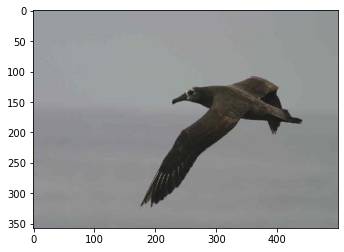

test_img_idx = 24
Processing 'blue wings' and 'wings without any blue' with similarities tensor([[0.8990]]) (between them), tensor([[0.2409]]) (pos emb), tensor([[0.2383]]) (neg emb)
contrastive probs scale of correct label 0 = tensor(0.4474)
cosine similarity probs of correct label 0 = 0.43520424
Processing 'brown wings' and 'wings without any brown' with similarities tensor([[0.9139]]) (between them), tensor([[0.2669]]) (pos emb), tensor([[0.2432]]) (neg emb)
contrastive probs scale of correct label 1 = tensor(0.8744)
cosine similarity probs of correct label 1 = 0.91435295
Processing 'yellow wings' and 'wings without any yellow' with similarities tensor([[0.8826]]) (between them), tensor([[0.2224]]) (pos emb), tensor([[0.2376]]) (neg emb)
contrastive probs scale of correct label 0 = tensor(0.7730)
cosine similarity probs of correct label 0 = 0.8205849
Processing 'green wings' and 'wings without any green' with similarities tensor([[0.8679]]) (between them), tensor([[0.2405]]) (pos em

In [53]:
import torch
import clip
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from cem.data.cub_loader import CONCEPT_SEMANTICS_SENTENCE, CONCEPT_SEMANTICS_NEGATION
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
img_selected = "001.Black_footed_Albatross/Black_Footed_Albatross_0008_796083.jpg" #"027.Shiny_Cowbird/Shiny_Cowbird_0007_24434.jpg"
im = Image.open(f"/homes/me466/data/CUB200/CUB_200_2011/images/{img_selected}")
plt.imshow(im)
plt.show()
test_img = preprocess(im).unsqueeze(0).to(device)
with open('/homes/me466/data/CUB200/CUB_200_2011/images.txt', 'r') as f:
    img_names = [x.rstrip().split(" ")[-1] for x in f]
test_img_idx = img_names.index(img_selected)
print("test_img_idx =", test_img_idx)
test_img_emb = model.encode_image(test_img)
test_img_emb = test_img_emb / test_img_emb.norm(dim=1, keepdim=True)
test_img_attrs = attributes[test_img_idx, :]
embeddings = []
with torch.no_grad():
    for idx, (pos_descr, neg_descr) in enumerate(zip(CONCEPT_SEMANTICS_SENTENCE, CONCEPT_SEMANTICS_NEGATION)):
        # idx = IDXs[idx]
        pos_text = clip.tokenize([pos_descr]).to(device)
        pos_emb = model.encode_text(pos_text)
        pos_emb = pos_emb / pos_emb.norm(dim=1, keepdim=True)
        neg_text = clip.tokenize([neg_descr]).to(device)
        neg_emb = model.encode_text(neg_text)
        neg_emb = neg_emb / neg_emb.norm(dim=1, keepdim=True)

        score_pos = (pos_emb - test_img_emb).pow(2).sum(-1).sqrt()
        score_neg = (neg_emb - test_img_emb).pow(2).sum(-1).sqrt()
        # probs = torch.sigmoid(
        #     score_neg - score_pos
        # )
        # probs = [1-probs, probs]
        # print("contrastive probs =", probs)
        
        cont_probs = torch.sigmoid(
            100 * (score_neg - score_pos)
        )
        cont_probs = [1-cont_probs, cont_probs]

        score_pos = pos_emb @ test_img_emb.t()
        score_neg = neg_emb @ test_img_emb.t()
        cos_probs = (model.logit_scale.exp() * torch.concat([score_neg, score_pos], dim=0)).softmax(dim=0).cpu().numpy()
        print(f"Processing '{pos_descr}' and '{neg_descr}' with similarities {pos_emb @ neg_emb.t()} (between them), {score_pos} (pos emb), {score_neg} (neg emb)")
        print(f"contrastive probs scale of correct label {test_img_attrs[idx]} =", cont_probs[test_img_attrs[idx]][0])
        print(f"cosine similarity probs of correct label {test_img_attrs[idx]} =", cos_probs[test_img_attrs[idx], 0])
        # probs = (torch.concat([score_neg, score_pos], dim=0)).softmax(dim=0)
        # print("cosine similarity probs no scale =", probs)
        
        embeddings.append((pos_emb, neg_emb))
embs = np.array([
    np.concatenate(x, axis=0)
    for x in embeddings
])

In [37]:
with open('../cub_ViT-B_32_concept_embeddings.npy', 'wb') as f:
    np.save(f, embs)

In [51]:
import torch
import clip
from PIL import Image

device = 'cpu'
model, preprocess = clip.load("ViT-B/32", device=device)
if not os.path.exists('/homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings'):
    os.makedirs('/homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings')
count = 0
for subdir, dirs, files in os.walk('/homes/me466/data/CUB200/CUB_200_2011/images/'):
    for file in files:
        if not file.endswith(".jpg"):
            continue
        count += 1

current_count = 0
batch_size = 512
current_batch = []
for subdir, dirs, files in os.walk('/homes/me466/data/CUB200/CUB_200_2011/images/'):
    for file in files:
        if not file.endswith(".jpg"):
            continue
        image_filename = os.path.join(subdir, file)
        dirname = os.path.dirname(image_filename)
        emb_directory = dirname.replace('/images/', '/clip_ViT-B_32_embeddings/')
        if not os.path.exists(emb_directory):
            os.makedirs(emb_directory)

        emb_filename = os.path.join(emb_directory, file.replace('jpg', 'npy'))
        image = preprocess(Image.open(image_filename)).unsqueeze(0).to(device)
        current_batch.append((image, emb_filename))
        if len(current_batch) == batch_size:
            print("Flushing the batch!")
            # Then time to fush the batch!
            with torch.no_grad():
                batch_of_images = torch.cat([x[0] for x in current_batch], axis=0)
                image_features = model.encode_image(batch_of_images)
                for idx, (_, current_file_name) in enumerate(current_batch):
                    print(f"\tSaving image {idx + 1}/{batch_size}")
                    with open(current_file_name, 'wb') as f:
                        np.save(f, image_features[idx, :])
            current_batch = []
        print(f"[{100 * current_count/count:.2f}%] Saving embedding for", image_filename, "to", emb_filename)
        current_count += 1


[0.00%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0001_794941.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0001_794941.npy
[0.01%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0029_1824.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0029_1824.npy
[0.02%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0074_794949.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0074_794949.npy
[0.03%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0045_794940.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0045_794940.npy
[0.03%] Saving embedding for /homes/me466/da

KeyboardInterrupt: 